# DSAIT4005 Machine and Deep Learning (2024/25 Q1)
# MLP, Non-linear, XOR

*Please post any feedback you have on Brightspace. Thanks!*

To start working on the assignment in Colab, save a copy on your Google Drive (`File` $\rightarrow$ `Save a copy in Drive`).

To work on the assignments locally, configure your conda environment (see instructions on Brightspace) and download this assignment as an IPython Notebook (`File` $\rightarrow$ `Download .ipynb`).

## Introduction

In this assignment you will be introduced to some basic functionality in PyTorch, you will write your own fully connected neural network layers and non-linear activation functions and will use those to solve a simple XOR classification problem.

**Prerequisites:**
* Basic knowledge of Python and Numpy. Recommended tutorial for Python and Numpy [here](https://cs231n.github.io/python-numpy-tutorial/).

**Learning objectives:**
* Using basic tensor operations in PyTorch;
* Understanding and implementing the forward pass of a fully connected layer and the ReLU and Sigmoid non-linear activation functions in PyTorch;
* Using basic PyTorch layers to build a simple neural network;
* Understanding and calculating the MSE loss;
* Understanding the training loop.

We will share the solutions one week after the assignments are published. Throughout the assignment you will validate your code by comparing the outputs of your own implementations to the equivalent PyTorch implementations.

**For your own implementations you may only use basic tensor operations from the `torch` module: no `torch.nn`, `torch.nn.F` or others. There is a small introduction into pytorch tensors in A1.0**


When answering coding questions make sure to write your own code within the designated part of the code block as illustrated here:

Please pay attention to the question boxes and try to think about them. The boxes are indicated as follows:

****
**Questions?**
****

In [1]:
# Setup
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

##A1.0 Tensors in Pytorch

Throughout the course, you will use the Pytorch library to design and evaluate your models. In those implementations you will (and must) often use Pytorch tensors (ranging from 1D to high-D). You have probably worked with `numpy` arrays quite much. Fortunately, creating and manipulating Pytorch tensors is highly similar. A detailed description of *how* to deal with them is given [here](https://colab.research.google.com/drive/1L9aMXms7ZXqjOktbwtH8H1VY8ixah6yU) (which is in *view* mode; for editing you must copy paste it).

It is encouraged to have a look as it will make solving the lab assignments easier.

## A1.1 Linear (fully connected) layer

In this first exercise, you will 1. implement the linear layer, 2. perform a forward pass on some dummy input, and 3. compare the output tensor to the *Pytorch* implementation of a linear layer.

A linear layer is defined as a fully-connected map from some input neurons to some output neurons. Say you have $N_{\text{in}}$ and $N_{\text{out}}$ neurons, there are a total of $N_{\text{in}} \cdot N_{\text{out}}$ connections (weigths) and $N_{\text{out}}$ biases. The fully-connected layer for some input vector $\mathbf{x} \in \mathbb{R}^{N_{\text{in}}}$, ouput vector $\mathbf{y}  \in \mathbb{R}^{N_{\text{out}}}$, weighting matrix $\mathbf{W}  \in \mathbb{R}^{N_{\text{in}} \times N_{\text{out}}} $, and bias vector $\mathbf{b}  \in \mathbb{R}^{N_{\text{out}}}$ is given by:

$$ \mathbf{y} = \mathbf{x}^T \mathbf{W} + \mathbf{b}$$

****
**What does $\mathbf{W}_{ij}$ represent exactly? What is the size of $\mathbf{W}$? And why is $\mathbf{x}$ tranposed?**
****

We will implement the linear layer as a Python *object*. Keep in mind that we want to be able to process multiple samples in one forward pass, so $\mathbf{x}$ will include a batch dimension such that $\mathbf{x} \in \mathbb{R}^{\text{batch},N_{\text{in}}}$ and $\mathbf{x}\mathbf{W}$ will become a matrix multiplication.

****
**Why would you want to do that? Hint: think bigger, literally ;)!**
****

In [2]:
import torch

class Linear(object):
    """
    Fully connected layer.

    Args:
        in_features: number of input features
        out_features: number of output features
    """

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        ########################################################################
        # Create placeholder tensors for weight and bias.                      #
        # Weight shape: (out_features, in_features)                            #
        # Bias shape:   (out_features,)                                        #
        ########################################################################
        self.weight = torch.empty(out_features, in_features)
        self.bias   = torch.empty(out_features)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.init_params()

    def init_params(self, std=0.1):
        """
        Initialize layer parameters. Sample weight from Gaussian distribution
        and bias uniform distribution.
        """
        self.weight = std * torch.randn_like(self.weight)
        self.bias   = torch.rand_like(self.bias)

    def forward(self, x):
        """
        Forward pass of Linear layer: multiply input tensor by weights and add bias.

        Args:
            x: input tensor of shape (batch_size, in_features)

        Returns:
            y: output tensor of shape (batch_size, out_features)
        """
        ########################################################################
        # Matrix multiply: x @ W^T (because W is (out_features, in_features))   #
        # Add bias (broadcasted across batch dimension).                        #
        ########################################################################
        y = x @ self.weight.t() + self.bias

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################
        return y

Now test the forward pass of the layer on some dummy input $\mathbf{x}$.

****
**What will be the shape of output tensor $\mathbf{y}$?**
****

In [3]:
# Define layer dimensions and dummy input
n_samples, in_features, out_features = 2, 3, 4
x = torch.randn((n_samples, in_features))

########################################################################
#          Create a layer from the Linear object class and forward pass #
########################################################################
layer = Linear(in_features, out_features)   # initialize linear layer
y = layer.forward(x)                        # run forward pass
########################################################################
#                         END OF YOUR CODE                             #
########################################################################
# What will be the shape of output tensor y?
print('Shape of output tensor y:', y.shape)
print('Shape of output tensor y correct: ', y.shape == torch.Size([n_samples, out_features]))

Shape of output tensor y: torch.Size([2, 4])
Shape of output tensor y correct:  True


If the forward pass has not returned any errors we can compare our implementation to the PyTorch linear layer [[docs](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)] from `torch.nn`. We do so by initializing a `nn.Linear` layer and setting the `weight` and `bias` to the same values as in our own linear layer.

PyTorch layers store their parameters as a `Parameter`, which is a `Tensor` subclass with some special properties [[docs](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)]. We therefore need to wrap our `layer.weight` and `layer.bias` in a `nn.Parameter` when using in `nn.Linear`. Moreover, the `weight` tensor is transposed in `nn.Linear`.

In [4]:
n_samples, in_features, out_features = 2, 3, 4
x = torch.randn((n_samples, in_features))

# Our custom Linear layer from before
layer = Linear(in_features, out_features)
y = layer.forward(x)

# Create equivalent PyTorch nn.Linear layer
torch_layer = nn.Linear(in_features, out_features)

# Copy parameters: note that nn.Linear stores weight as (out_features, in_features)
# but our custom layer had (out_features, in_features) already,
# so we don't need to transpose if we defined it that way.
torch_layer.weight = nn.Parameter(layer.weight.clone())
torch_layer.bias   = nn.Parameter(layer.bias.clone())

# Forward pass with torch layer
torch_y = torch_layer(x)

print('y is ', y)
print('Shape of output tensor y (custom):', y.shape)
print('Shape of output tensor torch_y (nn.Linear):', torch_y.shape)
print('Shape check correct:', torch_y.shape == torch.Size([n_samples, out_features]))

y is  tensor([[0.2158, 0.8575, 0.2915, 0.1840],
        [0.3200, 0.6820, 0.2303, 0.2612]])
Shape of output tensor y (custom): torch.Size([2, 4])
Shape of output tensor torch_y (nn.Linear): torch.Size([2, 4])
Shape check correct: True


We now compare the outputs of both implementations using `torch.allclose` [[docs](https://pytorch.org/docs/stable/generated/torch.allclose.html)], which returns `True` if all elements in both tensors are sufficiently "close" to each other (see documentation for what that means exactly).

Your forward implementation of the linear layer is *correct* if `True` is returned.

In [5]:
# Compare outputs using torch.allclose
outputs_same = torch.allclose(y, torch_y)
print('Outputs identical: ', outputs_same)

Outputs identical:  True


## A1.2 Non-linear activation functions

As the XOR problem cannot be solved by a simple linear classifier we require our neural network to be able to learn non-linear functions. This is where non-linear activation functions come into play. In this assignment we will implement the forward passes of two popular activation functions, namely the Rectified Linear Unit

$$
\text{ReLU}(x)=\max(0,x)
$$

and the Sigmoid function

$$
\sigma(x) = \frac{1}{1+\exp(-x)}
$$

To verify your implementation you will again compare against their PyTorch counterparts.

****
**Can you still remember from the lectures what the (dis)advantages are for each activation function? Think in terms of efficiency and effectiveness.**
****

In [6]:
class ReLU(object):
    """
    ReLU non-linear activation function.
    """

    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        """
        Forward pass of ReLU non-linear activation function: y=max(0,x).

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """

        y = torch.relu(x)
        return y



class Sigmoid(object):
    """
    Sigmoid non-linear activation function.
    """

    def forward(self, x):
        """
        Forward pass of Sigmoid non-linear activation function: y=1/(1+exp(-x)).

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """

        y = torch.sigmoid(x)
        return y

Test the forward pass of both non-linearities using the dummy input from before.

****
**Again: what will be shapes of the output tensors?**
****

In [7]:
y_relu = ReLU()
y_sigmoid = Sigmoid()

y_result_relu = y_relu.forward(x)
y_result_sigmoid = y_sigmoid.forward(x)
y_relu = y_result_relu
y_sigmoid = y_result_sigmoid
# What will be the shapes of output tensors y_relu and y_sigmoid?
print('Shape of ouput tensors y_relu and y_sigmoid:', y_result_relu.shape, y_result_sigmoid.shape)

Shape of ouput tensors y_relu and y_sigmoid: torch.Size([2, 3]) torch.Size([2, 3])


Now perform a forward pass with the ReLU and Sigmoid activation functions from `torch.nn` and compare the outputs to your implementation.

A list of all available non-linearities in PyTorch can be found [[here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)].

In [8]:
# ReLU forward pass
torch_relu = nn.ReLU()
torch_y_relu = torch_relu(x)

# Sigmoid forward pass
torch_sigmoid = nn.Sigmoid()
torch_y_sigmoid = torch_sigmoid(x)

# Compare outputs using torch.allclose
outputs_same = torch.allclose(y_relu, torch_y_relu)
print('ReLU outputs identical: ', outputs_same)
outputs_same = torch.allclose(y_sigmoid, torch_y_sigmoid)
print('Sigmoid outputs identical: ', outputs_same)

ReLU outputs identical:  True
Sigmoid outputs identical:  True


## A1.3 Network class

We will now create a base class for our neural network that will make it possible to stack individual layers on each other. For now we will only implement the forward pass.

In [9]:
class Net(object):
    """
    Neural network object containing layers.

    Args:
        layers: list of layers in neural network
    """

    def __init__(self, layers):
        self.layers = layers

    def reset_params(self, std=0.1):
        """
        Reset network parameters. Applies `init_params` to all layers with
        learnable parameters.

        Args:
            std: Standard deviation of Gaussian distribution (default: 0.1)
        """

        for layer in self.layers:
            if hasattr(layer, 'init_params'):
                layer.init_params(std=std)

    def forward(self, x):
        """
        Performs forward pass through all layers of the network.

        Args:
            x: input tensor

        Returns:
            x: output tensor
        """

        for layer in self.layers:
            x = layer.forward(x)
        return x

We will create a simple 2-layer network with ReLU non-linearity and test the forward pass using the same dummy input as before.

****
**What will be the shape of the output tensor?**
****

In [10]:
hidden_dim = 5

# Define and initialize layers
layers = [Linear(in_features, hidden_dim),
          ReLU(),
          Linear(hidden_dim, out_features)]

# Initialize network
net = Net(layers)

# Do forward pass
y = net.forward(x)

# What will be the shape of output tensor y?
print('Shape of ouput tensor y:', y.shape)

Shape of ouput tensor y: torch.Size([2, 4])


We will now create the same neural network in PyTorch. PyTorch uses the `nn.Module` base class for neural network architectures, which is similar to the `Net` object we have just defined. However, other than in the `Net` class, you have to define all layers inside the network definition.

This is an important exercise, as this is how you will define all your future models in PyTorch.

You can print a PyTorch `module` to see all sub-modules (i.e. layers) in the module.

In [11]:
# We will call the network TorchNet
class TorchNet(nn.Module):
    """
    PyTorch neural network. Network layers are defined in __init__ and forward
    pass implemented in forward.

    Args:
        in_features: number of features in input layer
        hidden_dim: number of features in hidden dimension
        out_features: number of features in output layer
    """

    def __init__(self, in_features, hidden_dim, out_features):
        super(TorchNet, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_features)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        """
        Performs forward pass through all layers of the network.

        Args:
            x: input tensor

        Returns:
            x: output tensor
        """

        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.out_act(x)
        return x

# Initialize Pytorch network
torch_net = TorchNet(in_features, hidden_dim, out_features)
print(torch_net)

TorchNet(
  (fc1): Linear(in_features=3, out_features=5, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=5, out_features=4, bias=True)
  (out_act): Sigmoid()
)


We will now again compare the outputs of the two networks. Therefore we again need to load the weights from our network into the PyTorch network.

In [12]:
# Copy parameters WITHOUT transposing
torch_net.fc1.weight = nn.Parameter(net.layers[0].weight.clone())  # (hidden, in)
torch_net.fc1.bias   = nn.Parameter(net.layers[0].bias.clone())

torch_net.fc2.weight = nn.Parameter(net.layers[2].weight.clone())  # (out, hidden)
torch_net.fc2.bias   = nn.Parameter(net.layers[2].bias.clone())

# Forward pass
torch_y = torch_net(x)
print('Shape of output tensor torch_y:', torch_y.shape)

# Compare outputs
print('Network outputs identical: ', torch.allclose(y, torch_y))

Shape of output tensor torch_y: torch.Size([2, 4])
Network outputs identical:  False


## A1.4: Introducing the XOR problem

To introduce the XOR classification problem that we will aim to solve in this assignment using a neural network we'll first generate and visualize the data points.

The `plot` function will also be used to visualize the decision boundaries of your neural network.

The XOR problem consists of 4 data points belonging to 2 classes which cannot be separated by a linear decision boundary.

| x0   | x1   | y    |
| ---- | ---- | ---- |
| 0    | 0    | 0    |
| 0    | 1    | 1    |
| 1    | 0    | 1    |
| 1    | 1    | 0    |

The class labels `y` are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics), i.e. for each class a binary value indicates whether the sample belongs to it or not. For instance, given classes `1,2,3,4,5` the one-hot encoding of class `4` is given by `[0,0,0,1,0]`. One-hot encoding is a natural way to represent class labels in a classification task since a neural network outputs a class probability vector. `[0,0,0,1,0]` then simply corresponds to a 0% chance of the sample belonging the classes `1,2,3,5` and a 100% chance of it belonging to class `4`.

In [13]:
x_xor = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y_xor = torch.tensor([[1, 0], [0, 1], [0, 1], [1, 0]]) # one-hot encoded

In [14]:
def plot(x, y, net=None):
    """
    Plotter function for XOR dataset and classifier boundaries (optional).

    Args:
        x: Nx2 dimensional data
        y: N dimensional labels
        net: Model which has a forward function
    """
    # Convert one-hot to class id
    y = torch.argmax(y, dim=1)

    # Plot decision boundary if net is given
    if net:
        h = 0.005
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1

        xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h),
                                torch.arange(y_min, y_max, h))

        in_tensor = torch.cat((xx.reshape((-1,1)), yy.reshape((-1,1))), dim=1)

        z = net.forward(in_tensor)
        z = torch.argmax(z, dim=1)
        z = z.reshape(xx.shape)
        plt.contourf(xx, yy, z, cmap=plt.cm.coolwarm)

    # Plot data points
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title('XOR problem')
    plt.xlabel('x0')
    plt.ylabel('x1')

    plt.show()

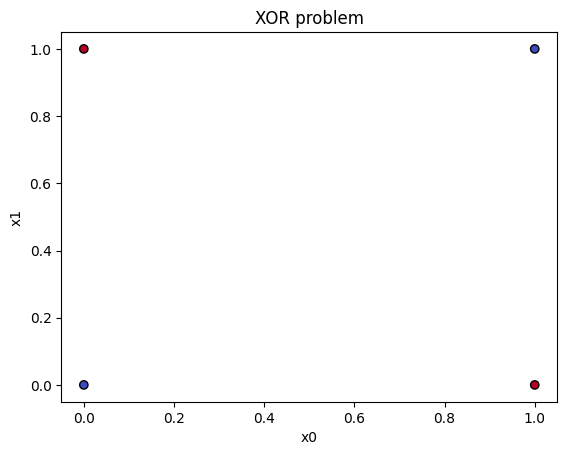

In [15]:
# Visualize
plot(x_xor, y_xor)

We will now use our non-linear neural network to solve the XOR problem.

To gain intuition with the transformations in a linear layer you will manually set the correct network parameters. Keep in mind that the network predicts class probabilities, i.e. for each sample it outputs the probability of belonging to class 0 and class 1.

In [16]:
import torch

# XOR data (0/1 inputs, 0/1 target)
x_xor = torch.tensor([[0.,0.],
                      [0.,1.],
                      [1.,0.],
                      [1.,1.]])
y_xor = torch.tensor([[0.],[1.],[1.],[0.]])

# Build your Net: 2 -> 2 -> 1 with sigmoids
layers = [
    Linear(2, 2),
    Sigmoid(),
    Linear(2, 1),
    Sigmoid()
]
net = Net(layers)

# Hand-set weights (k, m = large gains)
k, m = 10.0, 10.0

# hidden: rows are units; pre-activation = x @ W^T + b
net.layers[0].weight = torch.tensor([[k, k],
                                     [k, k]])
net.layers[0].bias   = torch.tensor([-0.5*k, -1.5*k])

# output: y_logit = [m, -m]·h + (-0.5*m), then final Sigmoid()
net.layers[2].weight = torch.tensor([[ m, -m ]])
net.layers[2].bias   = torch.tensor([-0.5*m])

# Forward and check
y_pred = net.forward(x_xor)
print("Pred probs:", y_pred.squeeze().round())   # → [0,1,1,0] (should match XOR)

Pred probs: tensor([0., 1., 1., 0.])


We will now increase the size of the hidden representation, i.e. the number of features between the first and second layer, from 2 to 5. Adjust the weights and biases in such a way that this new network yields exactly the same solution as the smaller network. It should be a fairly simple and straightforward modification.

*Hint: use the previous solution as a starting point.*

In [17]:
from torch import optim

X = torch.tensor([[0.,0.],
                  [0.,1.],
                  [1.,0.],
                  [1.,1.]])
y = torch.tensor([0,1,1,0])   # CrossEntropy expects 1D class indices

class TorchNet(nn.Module):
    def __init__(self, in_features=2, hidden_dim=5, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_features)  # logits for 2 classes
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

model = TorchNet()
opt = optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1000):
    opt.zero_grad()
    logits = model(X)              # (4,2)
    loss = loss_fn(logits, y)
    loss.backward()
    opt.step()

with torch.no_grad():
    pred = model(X).argmax(dim=1)
print("pred:", pred.tolist())      # → [0,1,1,0]

pred: [0, 1, 1, 0]


## A1.5 A first introduction to the training loop

Of course the power of a neural network lies in the fact that it is able to learn from data. We therefore now introduce the training loop. Roughly speaking the training loop consists of the following steps:
```
while not converged:
 1. feed training sample to network to predict output (forward step)
 2. compare prediction to label (compute loss)
 3. use comparison to update network parameters (backward step)
```
Since we have not yet implemented the backpropagation algorithm we will attempt to optimize our neural network in a rather primitive fashion by randomly generating weights until the problem is solved, i.e. all data points are classified correctly.

Even though a loss function is not required in our case, we will start by implementing the mean squared error loss to act as a heuristic. Given prediction $\hat{y}$ and groud-truth $y$ the MSE loss is defined as:
$$\text{MSE}(\hat{y},y)= \frac{1}{n} \sum_{i=1}^n (\hat{y}-y)^2 $$

Again keep in mind that $\hat{y}$ is a class probability vector and $y$ is a one-hot encoded representation.

In [18]:
def MSELoss(y_true, y_pred):
    """
    Computes mean squared error loss between y_true and y_pred.

    Args:
      y_true: Tensor containing true labels.
      y_pred: Tensor containing predictions.

    return:
      loss: Mean squared error loss
    """
    loss = nn.MSELoss()(y_true, y_pred)
    return loss

You will now implement our primitive training loop consisting of the steps:
```
while acc < 1:
 1. randomize network weights
 2. forward pass
 3. compute loss
 4. compute accuracy
 ```

tensor([[0.8169, 0.7929],
        [0.7664, 0.7931],
        [0.6367, 0.7017],
        [0.8170, 0.7900]])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


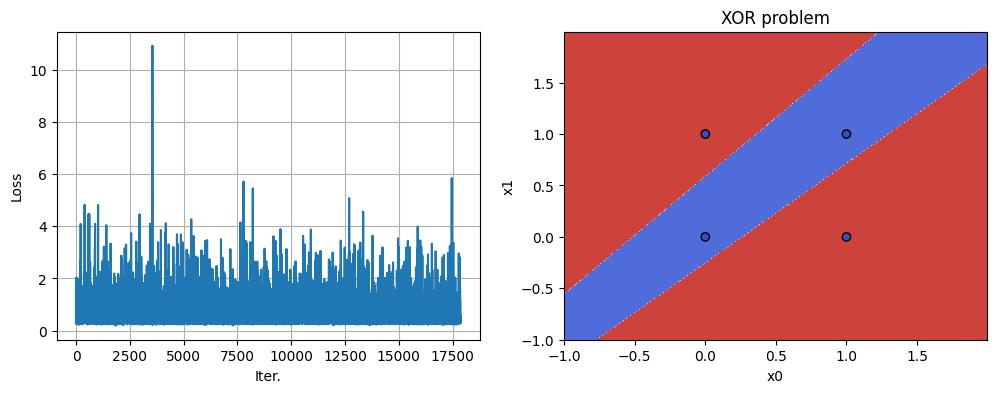

In [19]:
import torch
import matplotlib.pyplot as plt

import torch.nn.functional as F

# Define network dimensions
in_features, hidden_dim, out_features = 2, 2, 2

# Define and initialize layers
layers = [Linear(in_features, hidden_dim),
          ReLU(),
          Linear(hidden_dim, out_features)]

# Initialize network
net = Net(layers)

# Define list to store loss of each iteration
losses = []
# Initial accuracy is zero
acc = 0.0

# helper: one-hot
def to_one_hot(y_idx, num_classes):
    return torch.eye(num_classes)[y_idx]

losses = []
acc = 0.0

while acc < 1.0:
    # 1) Randomize network weights
    net.reset_params(std=0.5)

    # 2) Forward pass
    y_pred = net.forward(x_xor)                 # shape [N, 2]

    # Ensure labels are 1D long: [N]
    y_idx = y_xor.squeeze().long()

    # 3) MSE loss vs one-hot targets
    y_onehot = F.one_hot(y_idx, num_classes=out_features).float()  # [N,2]
    loss = ((y_pred - y_onehot) ** 2).mean()
    losses.append(loss.item())

    # 4) Accuracy
    pred_cls = y_pred.argmax(dim=1)
    acc = (pred_cls == y_idx).float().mean().item()

# Print output tensor
print(y_pred)

# Plot loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.grid()
plt.xlabel('Iter.')
plt.ylabel('Loss')

# Show decision boundary
plt.subplot(1,2,2)
plot(x_xor, y_xor, net)

This concludes the first assignment. You can experiment a bit with the network architecture and see how the various settings affect the decision boundary. For example:

****
- **What happens if the you increase/decrease the hidden dimension?**
- **What happens if you increase the number of network layers?**
- **What happens if you replace the ReLU non-linearity by a Sigmoid? Does the network still converge? If not, why? What setting(s) should you adjust to make the network converge again? (Hint: check the magnitude of the network predictions.**)
****